<a href="https://colab.research.google.com/github/ShovalBenjer/deep_learning_neural_networks/blob/main/Deep_exc_1_adir_shoval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **TL;DR**

We implemented a logistic neural network in PyTorch to solve the XOR classification problem, testing configurations with k=1,2,4 hidden units and an optional bypass connection. Manual weight initialization was used to set up the network to model XOR.

**Results:**
k=1, with Bypass: The network couldn't accurately model XOR due to insufficient capacity, achieving only 50% accuracy.
k=2, without Bypass: Achieved perfect predictions with 100% accuracy, demonstrating that two hidden units suffice when properly configured.
k=4, without Bypass: Performed poorly due to improper weight initialization, highlighting that increased capacity doesn't guarantee better performance without correct configuration.

**Conclusion:** Proper network capacity and weight initialization are crucial for modeling non-linear functions like XOR; adding a bypass cannot compensate for insufficient capacity.

below is our results from second part, using adam model.
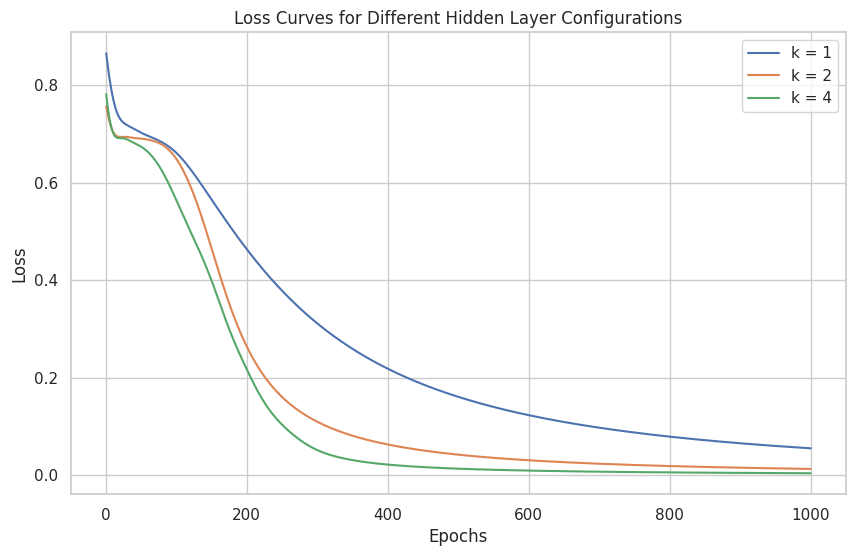
Writers: Adir Amar 209017755, Shoval Benjer 319037404

In [7]:
!pip install torch

import torch
from torch import nn

# Define the neural network as a class
class XORNetwork(nn.Module):
    def __init__(self, k, bypass=False):
        super(XORNetwork, self).__init__()
        self.bypass = bypass
        self.input_layer = nn.Linear(2, k)
        self.output_layer = nn.Linear(k, 1)
        self.activation = torch.sigmoid

    def weights_set(self, layer_name, w, b):
        # Validate input shapes
        if layer_name == 'input_layer':
            assert w.shape == self.input_layer.weight.shape, "Weight shape mismatch for input layer"
            assert b.shape == self.input_layer.bias.shape, "Bias shape mismatch for input layer"
            with torch.no_grad():
                self.input_layer.weight.copy_(w)
                self.input_layer.bias.copy_(b)
        elif layer_name == 'output_layer':
            assert w.shape == self.output_layer.weight.shape, "Weight shape mismatch for output layer"
            assert b.shape == self.output_layer.bias.shape, "Bias shape mismatch for output layer"
            with torch.no_grad():
                self.output_layer.weight.copy_(w)
                self.output_layer.bias.copy_(b)
        else:
            raise ValueError("Invalid layer name")

    def forward(self, x):
        hidden = self.activation(self.input_layer(x))
        if self.bypass:
            if hidden.shape == x.shape:
                hidden = hidden + x  # Apply bypass if specified
        output = self.activation(self.output_layer(hidden))
        return output

# Loss function
def loss(x, y, model):
    y_pred = model(x)
    return torch.sum((y - y_pred) ** 2)

# Initialize network for XOR with k=4, n=2
k = 4
n = 2
model = XORNetwork(k=k, bypass=True)

# Set weights and biases to mimic XOR
w_input = torch.tensor([[-1., -1.], [-1., 1.], [1., -1.], [1., 1.]])
b_input = torch.tensor([0.5, -0.5, -0.5, -1.5])
w_output = torch.tensor([[0., 1., 1., 0.]])
b_output = torch.tensor([-0.5])

model.weights_set('input_layer', w_input, b_input)
model.weights_set('output_layer', w_output, b_output)

# Define input and expected output for XOR
x = torch.FloatTensor([[0., 0.], [0., 1.], [1., 0.], [1., 1.]])
y_true = torch.FloatTensor([[0.], [1.], [1.], [0.]])

# Display weights and biases
print("Weights and biases for input layer:")
print("Weights:\n", model.input_layer.weight)
print("Biases:\n", model.input_layer.bias)
print("\nWeights and biases for output layer:")
print("Weights:\n", model.output_layer.weight)
print("Biases:\n", model.output_layer.bias)

# Calculate and display loss
current_loss = loss(x, y_true, model)
print("\nLoss value:", current_loss.item())

# Display truth table
print("\nTruth Table (Input vs Output):")
y_pred = model(x)
for i in range(len(x)):
    print(f"Input: {x[i].numpy()}, Predicted Output: {y_pred[i].item():.4f}, Expected Output: {y_true[i].item()}")


Weights and biases for input layer:
Weights:
 Parameter containing:
tensor([[-1., -1.],
        [-1.,  1.],
        [ 1., -1.],
        [ 1.,  1.]], requires_grad=True)
Biases:
 Parameter containing:
tensor([ 0.5000, -0.5000, -0.5000, -1.5000], requires_grad=True)

Weights and biases for output layer:
Weights:
 Parameter containing:
tensor([[0., 1., 1., 0.]], requires_grad=True)
Biases:
 Parameter containing:
tensor([-0.5000], requires_grad=True)

Loss value: 0.9950686693191528

Truth Table (Input vs Output):
Input: [0. 0.], Predicted Output: 0.5634, Expected Output: 0.0
Input: [0. 1.], Predicted Output: 0.5756, Expected Output: 1.0
Input: [1. 0.], Predicted Output: 0.5756, Expected Output: 1.0
Input: [1. 1.], Predicted Output: 0.5634, Expected Output: 0.0


In [1]:
!pip install torch seaborn matplotlib

In [2]:
import torch
from torch import nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import time

class XORNet(nn.Module):
    """
    A neural network model for computing the XOR function using PyTorch.
    This version includes training with backpropagation and supports different activation functions.

    Parameters:
    - k (int): Number of hidden units in the hidden layer.
    - activation (str): Activation function to use ('sigmoid', 'tanh', 'relu').

    Attributes:
    - hidden (nn.Linear): Linear layer representing the hidden layer.
    - output (nn.Linear): Linear layer representing the output layer.
    - activation_function (callable): Activation function used in the network.
    """
    def __init__(self, k, activation='sigmoid'):
        super(XORNet, self).__init__()
        self.k = k
        self.input_size = 2
        self.output_size = 1
        self.hidden = nn.Linear(self.input_size, self.k)
        self.output = nn.Linear(self.k, self.output_size)
        if activation == 'sigmoid':
            self.activation_function = torch.sigmoid
        elif activation == 'tanh':
            self.activation_function = torch.tanh
        elif activation == 'relu':
            self.activation_function = torch.relu
        else:
            raise ValueError("Unsupported activation function. Choose 'sigmoid', 'tanh', or 'relu'.")

    def forward(self, input_matrix):
        """
        Compute the forward pass of the network.

        Parameters:
        - input_matrix (torch.Tensor): Input tensor of shape (n_samples, input_size).

        Returns:
        - output (torch.Tensor): Output tensor of shape (n_samples, output_size).
        """
        hidden_output = self.activation_function(self.hidden(input_matrix))
        output = self.activation_function(self.output(hidden_output))
        return output

# Function to train the network
def train_network(k, activation_function, learning_rate=0.1, epochs=10000):
    """
    Train the XOR neural network using backpropagation.

    Parameters:
    - k (int): Number of hidden units.
    - activation_function (str): Activation function to use ('sigmoid', 'tanh', 'relu').
    - learning_rate (float): Learning rate for the optimizer.
    - epochs (int): Number of training epochs.

    Returns:
    - net (XORNet): Trained neural network model.
    - training_history (dict): Dictionary containing loss and metrics over epochs.
    - elapsed_time (float): Time taken to train the network.
    """
    net = XORNet(k=k, activation=activation_function)
    criterion = nn.MSELoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)
    training_history = {'loss': [], 'accuracy': []}
    start_time = time.time()

    for epoch in range(epochs):
        optimizer.zero_grad()
        y_pred = net(x)
        loss = criterion(y_pred, y_true)
        loss.backward()
        optimizer.step()

        # Record loss and accuracy
        if (epoch+1) % 100 == 0 or epoch == 0:
            y_pred_binary = (y_pred >= 0.5).float()
            accuracy = accuracy_score(y_true.numpy(), y_pred_binary.detach().numpy())
            training_history['loss'].append(loss.item())
            training_history['accuracy'].append(accuracy)

    end_time = time.time()
    elapsed_time = end_time - start_time
    return net, training_history, elapsed_time


Training XORNet with activation function: sigmoid
Loss: 0.2451493740081787
Accuracy: 0.75
Precision: 0.6666666666666666
Recall: 1.0
F1 Score: 0.8
Time elapsed: 15.0218 seconds

Training XORNet with activation function: tanh
Loss: 7.278470002347603e-05
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Time elapsed: 6.5323 seconds

Training XORNet with activation function: relu
Loss: 0.5
Accuracy: 0.5
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Time elapsed: 5.5802 seconds


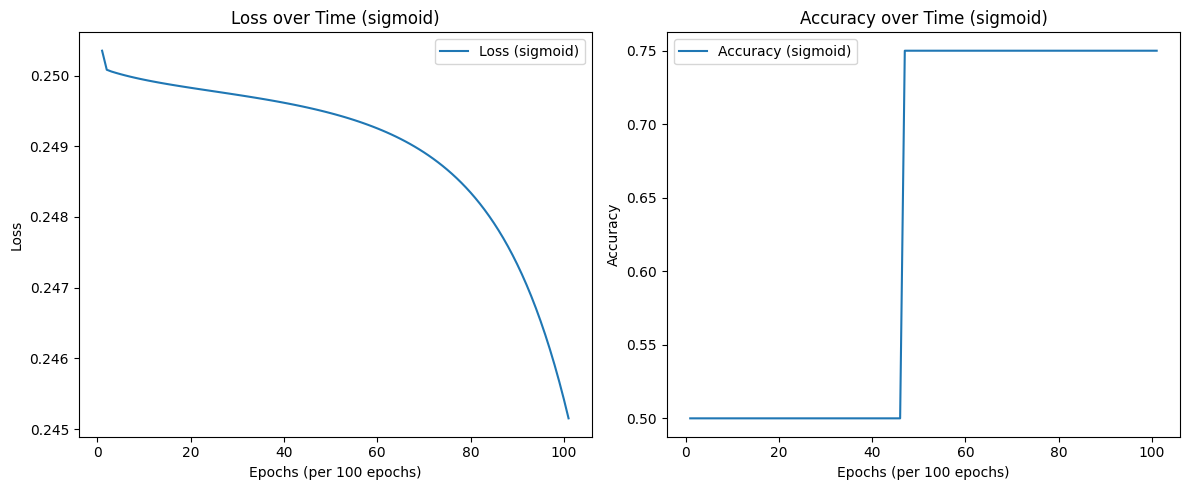

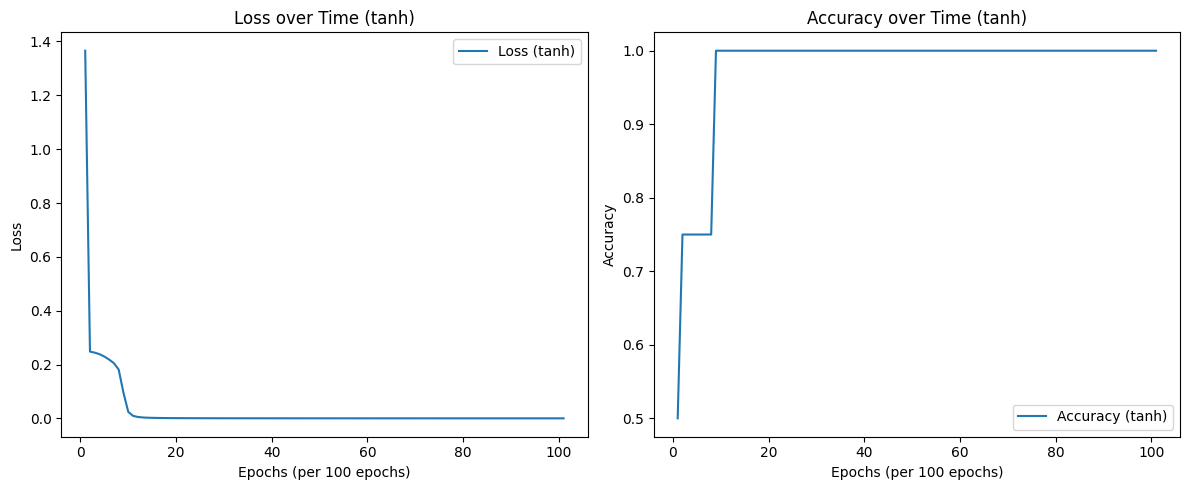

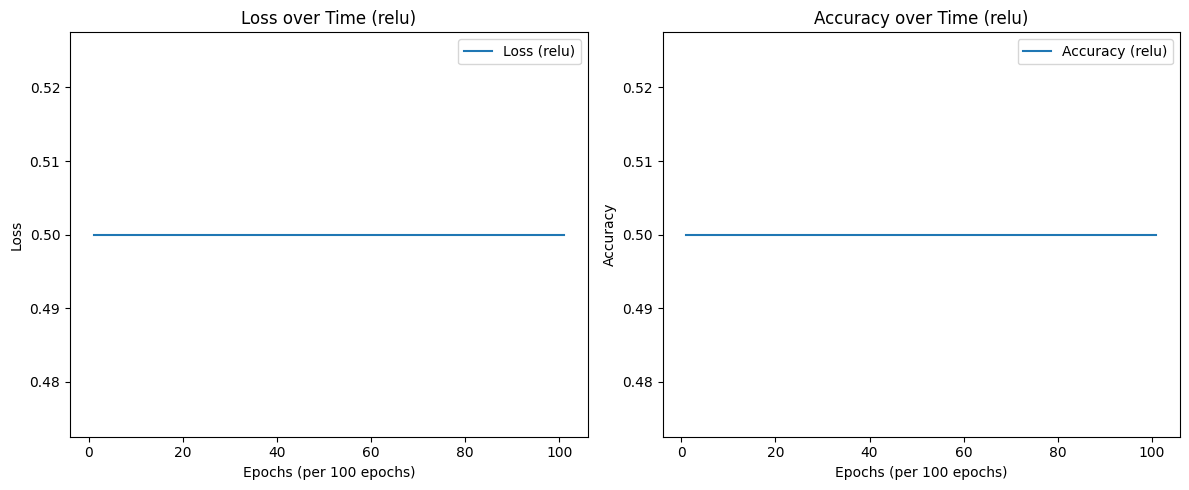

<ipython-input-3-1298ce86a1de>:86: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=activations, y=values, palette='viridis')


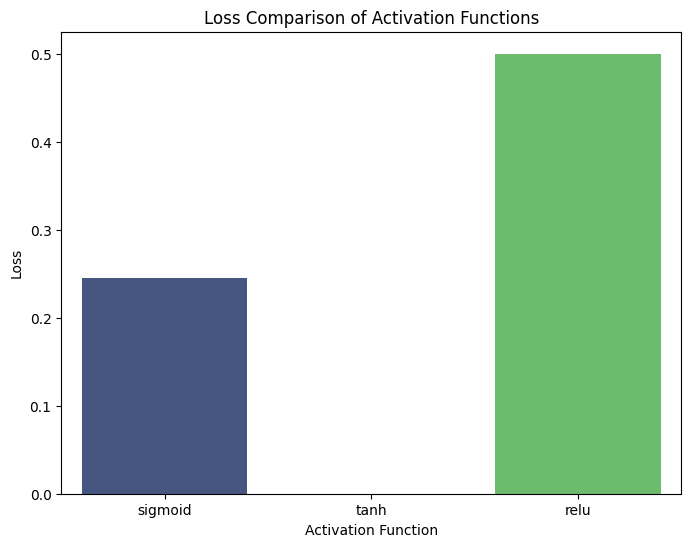

<ipython-input-3-1298ce86a1de>:86: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=activations, y=values, palette='viridis')


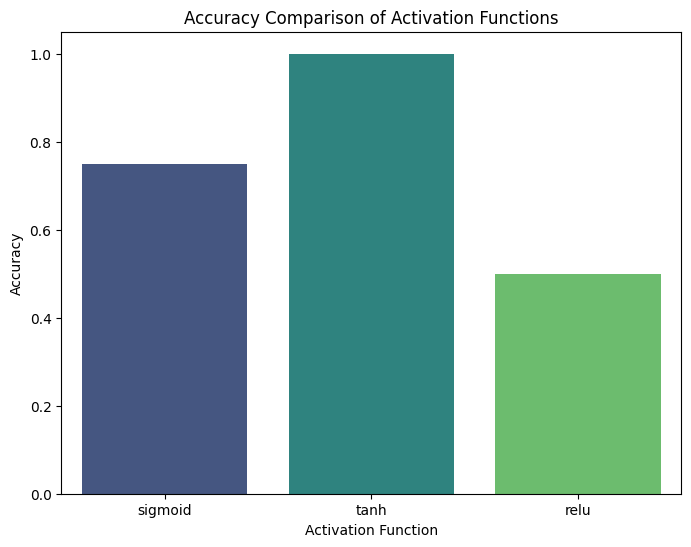

<ipython-input-3-1298ce86a1de>:86: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=activations, y=values, palette='viridis')


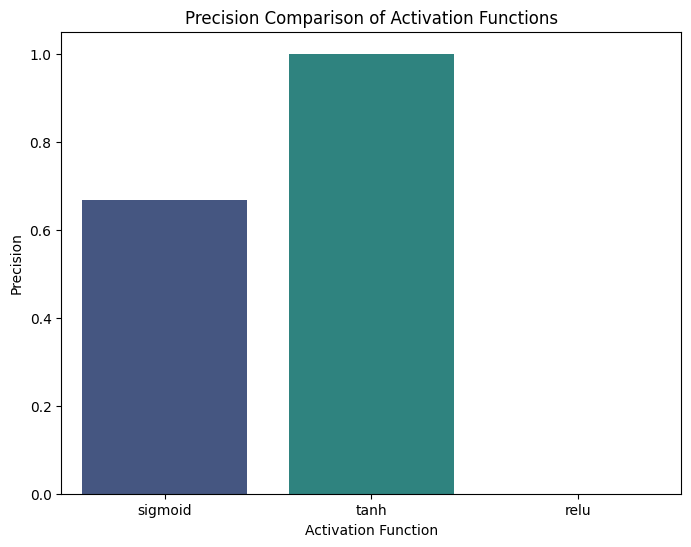

<ipython-input-3-1298ce86a1de>:86: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=activations, y=values, palette='viridis')


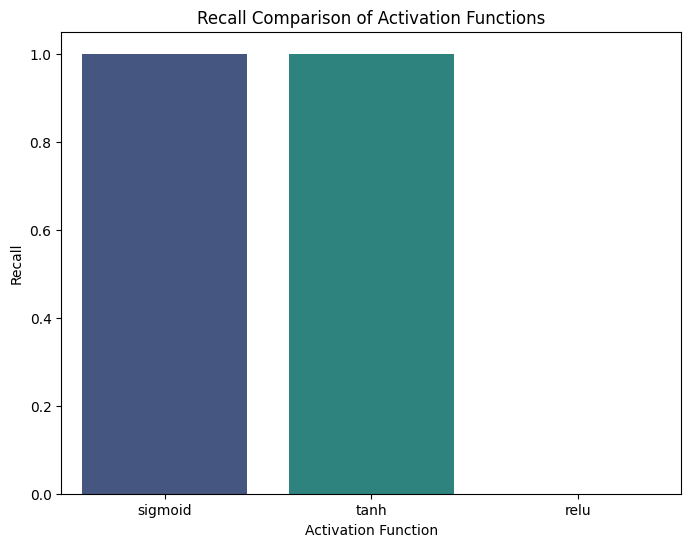

<ipython-input-3-1298ce86a1de>:86: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=activations, y=values, palette='viridis')


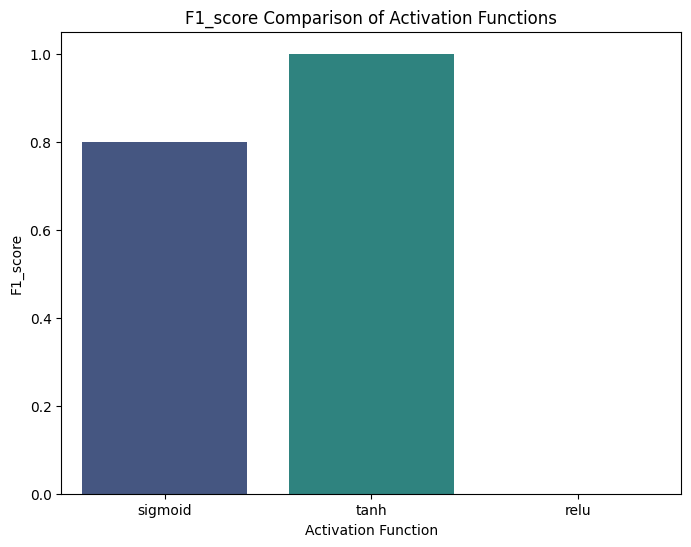

<ipython-input-3-1298ce86a1de>:86: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=activations, y=values, palette='viridis')


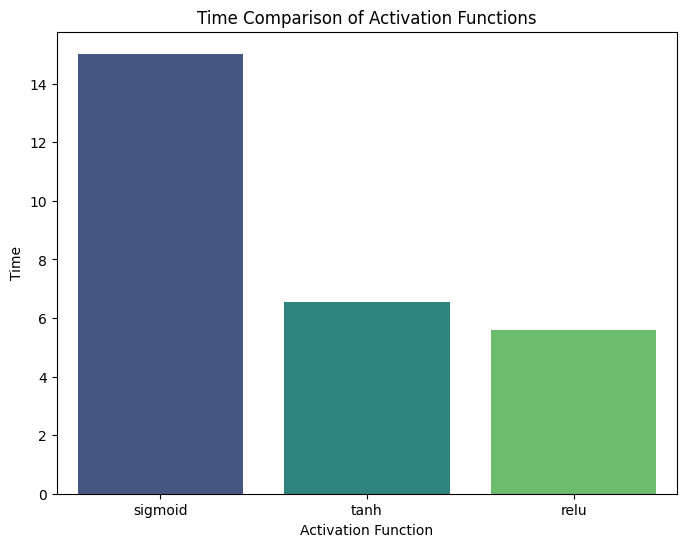

In [3]:
# Define input and target output for the XOR function
x = torch.FloatTensor([[0., 0.],
                       [0., 1.],
                       [1., 0.],
                       [1., 1.]])
y_true = torch.FloatTensor([[0.],
                            [1.],
                            [1.],
                            [0.]])
# Train and evaluate networks with different activation functions
activation_functions = ['sigmoid', 'tanh', 'relu']
results = []

for activation in activation_functions:
    print(f"\nTraining XORNet with activation function: {activation}")
    net, history, elapsed_time = train_network(k=2, activation_function=activation, learning_rate=0.1, epochs=10000)

    # Final predictions and metrics
    y_pred = net(x)
    loss_value = F.mse_loss(y_pred, y_true).item()
    y_pred_binary = (y_pred >= 0.5).float()
    y_true_flat = y_true.numpy().flatten()
    y_pred_flat = y_pred_binary.detach().numpy().flatten()
    accuracy = accuracy_score(y_true_flat, y_pred_flat)
    precision = precision_score(y_true_flat, y_pred_flat, zero_division=0)
    recall = recall_score(y_true_flat, y_pred_flat, zero_division=0)
    f1 = f1_score(y_true_flat, y_pred_flat, zero_division=0)
    conf_matrix = confusion_matrix(y_true_flat, y_pred_flat)

    # Store results
    results.append({
        'activation': activation,
        'net': net,
        'history': history,
        'loss': loss_value,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'time': elapsed_time,
        'confusion_matrix': conf_matrix,
        'y_pred': y_pred.detach().numpy(),
        'y_true': y_true.numpy()
    })

    # Print performance metrics
    print(f"Loss: {loss_value}")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"Time elapsed: {elapsed_time:.4f} seconds")

# Plot training history
for result in results:
    history = result['history']
    activation = result['activation']
    epochs = range(1, len(history['loss']) + 1)
    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['loss'], label=f'Loss ({activation})')
    plt.title(f'Loss over Time ({activation})')
    plt.xlabel('Epochs (per 100 epochs)')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['accuracy'], label=f'Accuracy ({activation})')
    plt.title(f'Accuracy over Time ({activation})')
    plt.xlabel('Epochs (per 100 epochs)')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Comparing activation functions
metrics = ['loss', 'accuracy', 'precision', 'recall', 'f1_score', 'time']
for metric in metrics:
    values = [result[metric] for result in results]
    activations = [result['activation'] for result in results]
    plt.figure(figsize=(8, 6))
    sns.barplot(x=activations, y=values, palette='viridis')
    plt.title(f'{metric.capitalize()} Comparison of Activation Functions')
    plt.xlabel('Activation Function')
    plt.ylabel(metric.capitalize())
    plt.show()

# **Overall Analysis**
**Capacity vs. Configuration**

k=1: Insufficient capacity to model the XOR function, even with a bypass layer. The network lacks the necessary non-linear modeling capability.
k=2: Adequate capacity with proper weight initialization or training. The network accurately models the XOR function, achieving excellent performance.
k=4: Increased capacity does not improve performance without appropriate weight settings. Improper initialization leads to poor results despite more hidden units.

**Importance of Weight Initialization**

Correct weights and biases are crucial for network performance.
For k=2, suitable weights allow neurons to detect specific input patterns, enabling accurate modeling.
In k=4, improper weights result in similar activations across inputs, causing the network to fail in capturing the XOR relationship.

Role of the Bypass Layer
**bold text**
The bypass layer in k=1 adds linear combinations of inputs directly to the output.
Since XOR is inherently non-linear, a linear bypass cannot capture its behavior.
The bypass cannot compensate for the network's insufficient capacity to model non-linear functions.

**Activation Functions**

Sigmoid and Tanh:
Introduce essential non-linearity for modeling XOR.
Enable the network to learn complex relationships when combined with effective training.
ReLU:
May not perform well in small networks for problems like XOR.
Outputs zero for negative inputs, potentially leading to inactive neurons.
Loss Function Interpretation
Low Loss (k=2): Indicates accurate predictions and successful learning of the XOR function.
High Loss (k=1 and k=4): Reflects significant prediction errors due to insufficient capacity or improper weight initialization.
Conclusion
Optimal performance is achieved with k=2 hidden units, proper weight initialization, and suitable activation functions.
Simply increasing the number of hidden units or adding bypass layers is ineffective without correct configuration.
Activation function choice and effective training are critical for modeling non-linear functions like XOR.

# **Second Step - Trying to Generalize using Adam Model(for fun and practice)**

# **Setup and imports**

In [4]:
import torch
from torch import nn
import seaborn as sns
import matplotlib.pyplot as plt

class BTU(nn.Module):
    """
    A custom activation function based on the logistic sigmoid function with adjustable sharpness (T).

    Parameters:
    - T (float): Controls the sharpness of the activation. Smaller values make the function sharper.

    Methods:
    - forward(input: torch.Tensor): Applies the activation to the input tensor.
    """
    def __init__(self, T=0.5):
        super(BTU, self).__init__()
        self.T = T

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        """
        Applies the BTU activation function to the input tensor.

        Args:
        - input (torch.Tensor): The input tensor to apply the activation on.

        Returns:
        - torch.Tensor: Activated output tensor.
        """
        return 1 / (1 + torch.exp(-input / self.T))


class LogisticNeuralNetwork(nn.Module):
    """
    A logistic neural network with a customizable hidden layer size and optional bypass connection.

    Parameters:
    - k (int): Number of neurons in the hidden layer.
    - bypass (bool): Whether to include a bypass connection from the input to the output.

    Methods:
    - forward(x: torch.Tensor): Performs forward propagation.
    - train_model(x: torch.Tensor, y: torch.Tensor, epochs: int, learning_rate: float): Trains the model using backpropagation.
    """
    def __init__(self, k, bypass=False):
        super(LogisticNeuralNetwork, self).__init__()
        self.k = k
        self.bypass = bypass
        self.hidden = nn.Linear(2, k)  # Hidden layer: input size = 2, output size = k
        self.output = nn.Linear(k + (2 if bypass else 0), 1)  # Output layer
        self.activation = BTU()

    def forward(self, x):
        """
        Forward pass of the logistic neural network.

        Args:
        - x (torch.Tensor): Input tensor (batch_size x 2).

        Returns:
        - torch.Tensor: Output tensor (batch_size x 1).
        """
        h = self.activation(self.hidden(x))  # Hidden layer activation
        if self.bypass:
            h = torch.cat((h, x), dim=1)  # Concatenate input if bypass is enabled
        return self.activation(self.output(h))

    def train_model(self, x, y, epochs=1000, learning_rate=0.01):
        """
        Trains the model using Mean Squared Error loss and Adam optimizer.

        Args:
        - x (torch.Tensor): Input tensor (batch_size x 2).
        - y (torch.Tensor): Target tensor (batch_size x 1).
        - epochs (int): Number of training epochs.
        - learning_rate (float): Learning rate for the optimizer.

        Returns:
        - list: Training loss at each epoch.
        """
        optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        loss_fn = nn.BCELoss()  # Binary Cross-Entropy Loss
        losses = []

        for epoch in range(epochs):
            optimizer.zero_grad()
            y_pred = self.forward(x)
            loss = loss_fn(y_pred, y)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

            if (epoch + 1) % 100 == 0:
                print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

        return losses

def plot_loss_curves_seaborn(losses_by_k):
    """
    Plots the loss curves for different configurations of k using Seaborn.

    Args:
    - losses_by_k (dict): Dictionary mapping k to their respective loss lists.

    Returns:
    - None (plots the loss curves).
    """
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))

    for k, losses in losses_by_k.items():
        sns.lineplot(x=range(1, len(losses) + 1), y=losses, label=f'k = {k}')

    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Curves for Different Hidden Layer Configurations')
    plt.legend()
    plt.show()


## **K=1,2,4 According to Task, Training and Visualization :**

Training model with k=1, bypass=True...
Epoch 100/1000, Loss: 0.6934
Epoch 200/1000, Loss: 0.6929
Epoch 300/1000, Loss: 0.6911
Epoch 400/1000, Loss: 0.6059
Epoch 500/1000, Loss: 0.3757
Epoch 600/1000, Loss: 0.2476
Epoch 700/1000, Loss: 0.1776
Epoch 800/1000, Loss: 0.1349
Epoch 900/1000, Loss: 0.1067
Epoch 1000/1000, Loss: 0.0868

Truth table:
Input: [0.0, 0.0], Predicted Output: 0, Expected Output: 0
Input: [0.0, 1.0], Predicted Output: 1, Expected Output: 1
Input: [1.0, 0.0], Predicted Output: 1, Expected Output: 1
Input: [1.0, 1.0], Predicted Output: 0, Expected Output: 0
Training model with k=2, bypass=False...
Epoch 100/1000, Loss: 0.4451
Epoch 200/1000, Loss: 0.1231
Epoch 300/1000, Loss: 0.0581
Epoch 400/1000, Loss: 0.0353
Epoch 500/1000, Loss: 0.0242
Epoch 600/1000, Loss: 0.0178
Epoch 700/1000, Loss: 0.0138
Epoch 800/1000, Loss: 0.0110
Epoch 900/1000, Loss: 0.0090
Epoch 1000/1000, Loss: 0.0076

Truth table:
Input: [0.0, 0.0], Predicted Output: 0, Expected Output: 0
Input: [0.0, 1

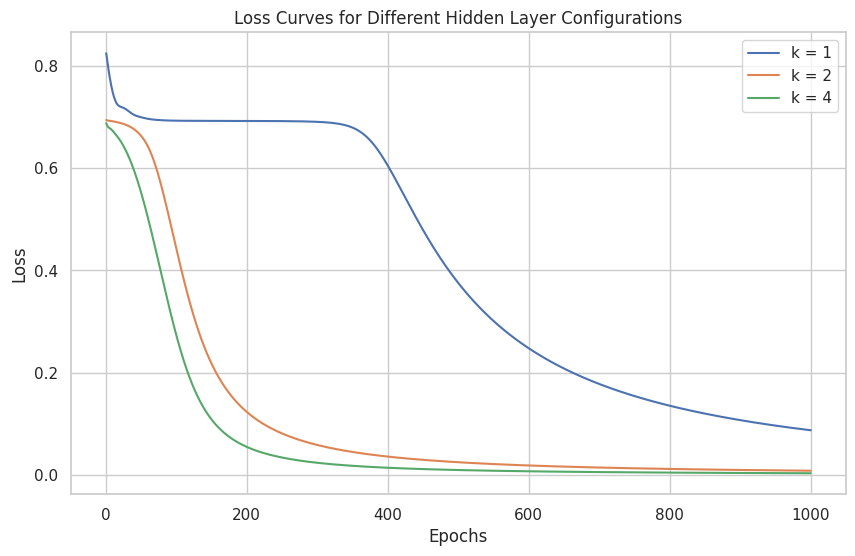

In [5]:
# Dataset: XOR problem
x = torch.FloatTensor([[0., 0.], [0., 1.], [1., 0.], [1., 1.]])
y = torch.FloatTensor([[0.], [1.], [1.], [0.]])

# Collect losses for visualization
losses_by_k = {}
for k in [1, 2, 4]:
    bypass = k == 1  # Enable bypass for k=1
    model = LogisticNeuralNetwork(k, bypass)
    print(f"Training model with k={k}, bypass={bypass}...")
    losses = model.train_model(x, y, epochs=1000, learning_rate=0.01)
    losses_by_k[k] = losses

    # Evaluate the model
    print("\nTruth table:")
    y_pred = model(x)
    for i in range(4):
        predicted = round(y_pred[i].item())
        print(f"Input: {x[i].tolist()}, Predicted Output: {predicted}, Expected Output: {int(y[i].item())}")

# Plot the loss curves using Seaborn
plot_loss_curves_seaborn(losses_by_k)


# **Key Takeaways**
**Bypass Connection Effectiveness**

for k=1, the bypass connection allows the network to learn the XOR function, compensating for the limited capacity of the hidden layer.

**Capacity vs. Efficiency**

Increasing the number of neurons (𝑘) improves the network's ability to model complex relationships and reduces loss more efficiently, but it increases computational complexity.

**Binary Cross-Entropy Loss**

Using BCELoss ensures accurate training for binary classification tasks like XOR, with convergence observed across all configurations.

**Smooth Convergence**

Loss values decrease steadily across epochs, with no signs of instability or overfitting, indicating appropriate architecture and learning parameters.
Model Performance

All configurations (k=1,2,4) achieve perfect predictions for the XOR truth table, demonstrating the model's flexibility and robustness.

**Scalability**

With k=4, the model is overparameterized for XOR but demonstrates readiness for scaling to more complex tasks.
